In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_05 import *

[Jump_to notebook introduction in lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=3167)

# Data

In [3]:
x_train, y_train, x_valid, y_valid = get_data()
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
nh, bs = 50, 512
c = y_train.max().item() + 1
loss_func = F.cross_entropy

In [4]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)
len(data.train_ds), len(data.valid_ds)

(50000, 10000)

In [5]:
len(data.train_dl), len(data.valid_dl)

(98, 10)

# Helpful Functions

In [6]:
def listify(obj):
    """Convert `obj` to list"""
    if obj is None:
        return []
    if isinstance(obj, str):
        return [obj]
    if isinstance(obj, list):
        return obj
    if isinstance(obj, Iterable):
        return list(obj)
    return [obj]

In [7]:
listify('test'), listify(None), listify((1, 2)), listify([1]), listify(2)

(['test'], [], [1, 2], [1], [2])

In [8]:
def camel2snake(name):
    """
    Convert name of callback by inserting underscores between small and capital
    letters. For example, `TestCallback` becomes `test_callback`.
    """
    pattern1 = re.compile("(.)([A-Z][a-z]+)")
    pattern2 = re.compile("([a-z0-9])([A-Z])")
    name = re.sub(pattern1, r"\1_\2", name)
    return re.sub(pattern2, r"\1_\2", name).lower()

In [9]:
camel2snake('TestCallbackAnotherTest')

'test_callback_another_test'

In [10]:
pattern1 = re.compile("(.)([A-Z][a-z]+)")
pattern2 = re.compile("([a-z0-9])([A-Z])")
name = re.sub(pattern1, r"\1_\2", 'TestCallbackAnotherTest')
name

'Test_CallbackAnother_Test'

# Callbacks

Basic class handling tweaks of the training loop by changing a [Learner](https://dev.fast.ai/13a_learner#Learner) in various events.

The training loop consists of a minimal set of instructions; looping through the data we:
- compute the output of the model from the input
- calculate a loss between this output and the desired target
- compute the gradients of this loss with respect to all the model parameters
- update the parameters accordingly
- zero all the gradients

Any tweak of this training loop is defined in a [Callback](https://dev.fast.ai/callback.core#Callback) to avoid over-complicating the code of the training loop, and to make it easy to mix and match different techniques (since they'll be defined in different callbacks). A callback can implement actions on the following events:
1. `begin_fit`: called before doing anything, ideal for initial setup.
1. `begin_epoch`: called at the beginning of each epoch, useful for any behavior you need to reset at each epoch.
1. `begin_train`: called at the beginning of the training part of an epoch.
1. `begin_batch`: called at the beginning of each batch, just after drawing said batch. It can be used to do any setup necessary for the batch (like hyper-parameter scheduling) or to change the input/target before it goes in the model (change of the input with techniques like mixup for instance).
1. `after_pred`: called after computing the output of the model on the batch. It can be used to change that output before it's fed to the loss.
1. `after_loss`: called after the loss has been computed, but before the backward pass. It can be used to add any penalty to the loss (AR or TAR in RNN training for instance).
1. `after_backward`: called after the backward pass, but before the update of the parameters. It can be used to do any change to the gradients before said update (gradient clipping for instance).
1. `after_step`: called after the step and before the gradients are zeroed.
1. `after_batch`: called at the end of a batch, for any clean-up before the next one.
1. `after_train`: called at the end of the training phase of an epoch.
1. `begin_validate`: called at the beginning of the validation phase of an epoch, useful for any setup needed specifically for validation.
1. `after_validate`: called at the end of the validation part of an epoch.
1. `after_epoch`: called at the end of an epoch, for any clean-up before the next one.
1. `after_fit`: called at the end of training, for final clean-up.

In [11]:
# export
class Callback:
    # Determines the order of the when each callback is run; useful when
    # are dealing with transformation
    _order = 0
    def set_runner(self, run): 
        self.run = run

    # This is used if we try to access a callback attribute
    # but most likely the attribute is from runner.
    def __getattr__(self, k):
        return getattr(self.run, k)

    @property
    def name(self):
        '''
        Returns the name of the callback after removing the word `callback` 
        and then convert it to snake (split words by underscores).
        '''
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')

    # We have this method here so that the user has more flexibility
    # about what to do when each callback is called. we can just change
    # the behavior of the __call__ method
    def __call__(self, cb_name):
        f = getattr(self, cb_name, None)
        if f and f():
            return True
        return False

In [12]:
# export
class TrainEvalCallback(Callback):
    """
    Tracks the number of iterations and epoch done and set training and eval
    modes.
    """
    def begin_fit(self):
        self.run.n_iters = 0
        self.run.pct_train = 0

    def after_batch(self):
        if self.run.training:
            self.run.n_iters += 1
            self.run.pct_train += 1 / (self.iters * self.n_epochs)

    def begin_train(self):
        self.model.train()
        self.run.training = True
        self.run.pct_train = self.epoch / self.n_epochs

    def begin_validate(self):
        self.run.training = False
        self.model.eval()

In [13]:
# export
class CancelTrainException(Exception):
    '''Stop training.'''
    pass


class CancelEpochException(Exception):
    '''Stop current epoch and move to next epoch.'''
    pass


class CancelBatchException(Exception):
    '''Stop current batch and move to next one.'''
    pass


class CancelValidException(Exception):
    '''Stop validation phase and move to next'''
    pass

class CancelFitException(Exception):
    pass

In [14]:
# export
class Runner:
    def __init__(self, cbs=None, cb_funcs=None):
        self.cbs = listify(cbs)
        for cb_func in listify(cb_funcs):
            cb = cb_func()
            setattr(self, cb.name, cb)
            self.cbs.append(cb)
        self.cbs = [TrainEvalCallback()] + self.cbs

    @property
    def model(self):
        return self.learn.model

    @property
    def opt(self):
        return self.learn.opt

    @property
    def loss_func(self):
        return self.learn.loss_func

    @property
    def data(self):
        return self.learn.data

    def _one_batch(self, xb, yb):
        self.xb, self.yb = xb, yb
        try:
            self('begin_batch')
            self.pred = self.model(self.xb)
            self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb)
            self('after_loss')
            if not self.training:
                return
            self.loss.backward()
            self('after_backward')
            self.opt.step()
            self('after_step')
            self.opt.zero_grad()
        except CancelBatchException:
            self('after_cancel_batch')
        finally:
            self('after_batch')

    def _all_batches(self, dl):
        self.iters = len(dl)
        for xb, yb in dl:
            self._one_batch(xb, yb)
        
    def fit(self, epochs, learn):
        self.n_epochs = epochs
        self.learn = learn

        try:
            for cb in self.cbs:
                cb.set_runner(self)

            self('begin_fit')
            for epoch in range(self.n_epochs):
                try:
                    self('begin_epoch')
                    self.epoch = epoch
                
                    try:
                        self('begin_train') 
                        self._all_batches(self.data.train_dl)
                    except CancelTrainException:
                        self('after_cancel_train')
                    finally:
                        self('after_train')

                    try:
                        self('begin_validate')
                        with torch.no_grad():
                                self._all_batches(self.data.valid_dl)
                    except CancelValidException:
                        self('after_cancel_validate')
                    finally:
                        self('after_validate')
                except CancelEpochException:
                    self('after_cancel_epoch')
                finally:
                    self('after_epoch')
        except CancelFitException:
            self('after_cancel_fit')
        finally:
            self('after_fit')
            self.learn = None

    def __call__(self, cb_name):
        res = False
        for cb in sorted(self.cbs, key=lambda x: x._order):
            res = cb(cb_name) or res
        return res

In [15]:
learn = create_learner(get_model, loss_func, data)

In [16]:
class TestCallback(Callback):
    _order = 1

    def after_step(self):
        print(self.n_iters, self.pct_train)
        if self.n_iters >= 10:
            raise CancelFitException()

In [17]:
run = Runner(cb_funcs=TestCallback)

In [18]:
run.fit(3, learn)

0 0.0
1 0.003401360544217687
2 0.006802721088435374
3 0.01020408163265306
4 0.013605442176870748
5 0.017006802721088433
6 0.02040816326530612
7 0.023809523809523808
8 0.027210884353741496
9 0.030612244897959183
10 0.03401360544217687


# Useful callbacks

## Stats

In [19]:
# export
class AvgStats():
    def __init__(self, metrics, training=True):
        self.metrics = listify(metrics)
        self.training = training

    def reset(self):
        self.tot_loss = 0
        self.count = 0
        self.tot_metrics = [0.] * len(self.metrics)

    @property
    def all_stats(self):
        '''Returns a list of both loss and metrics.'''
        return [self.tot_loss.item()] + self.tot_metrics

    @property
    def avg_stats(self):
        '''Returns the average of loss/metrics.'''
        return [o / self.count for o in self.all_stats]

    def __repr__(self):
        if not self.count: 
            return ''
        return f"{'train' if self.training else 'valid'}: {self.avg_stats}"

    def accumulate(self, run):
        '''Evaluate metrics and accumulate them to at the epoch level.'''
        bs = len(run.xb)
        self.count += bs
        self.tot_loss += run.loss * bs
        for i, metric in enumerate(self.metrics):
            self.tot_metrics[i] += metric(run.pred, run.yb) * bs

In [20]:
# export
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats = AvgStats(metrics, True)
        self.valid_stats = AvgStats(metrics, False)

    def begin_epoch(self):
        '''Reset metrics/loss.'''
        self.train_stats.reset()
        self.valid_stats.reset()

    def after_loss(self):
        '''Evaluate metrics and accumulate them.'''
        stats = self.train_stats if self.training else self.valid_stats
        with torch.no_grad():
            stats.accumulate(self.run)

    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)

In [21]:
learn = create_learner(get_model, loss_func, data)

In [22]:
run = Runner(cbs=AvgStatsCallback([accuracy]))

In [23]:
run.fit(3, learn)

train: [0.662962890625, tensor(0.8047)]
valid: [0.3084689208984375, tensor(0.9096)]
train: [0.301999140625, tensor(0.9106)]
valid: [0.255448876953125, tensor(0.9270)]
train: [0.2453689453125, tensor(0.9282)]
valid: [0.216102001953125, tensor(0.9378)]


## Recorder

In [24]:
# export
class Recorder(Callback):
    def begin_train(self):
        self.lrs = [[] for _ in self.opt.param_groups]
        self.losses = []

    def after_batch(self):
        if not self.training:
            return
        for pg, lr in zip(self.opt.param_groups, self.lrs):
            lr.append(pg['lr'])
        self.losses.append(self.loss.detach().cpu())
#         print(len(self.losses), len(self.lrs[0]))

    def plot_lr(self, pgid=-1):
        plt.plot(self.lrs[pgid])

    def plot_loss(self, skip_last=0):
        n = len(self.losses) - skip_last
        plt.plot(self.losses[:n])

    def plot(self, skip_last=0, pgid=-1):
        losses = [o.item() for o in self.losses]
        lrs = self.lrs[pgid]
        n = len(losses) - skip_last
        plt.xscale('log')
        plt.plot(lrs[:n], losses[:n])

In [25]:
learn = create_learner(get_model, loss_func, data)

In [26]:
run = Runner(cbs=AvgStatsCallback([accuracy]), cb_funcs=Recorder)

In [27]:
run.fit(3, learn)

train: [0.65667796875, tensor(0.8085)]
valid: [0.3236411376953125, tensor(0.9039)]
train: [0.29540583984375, tensor(0.9133)]
valid: [0.2410597412109375, tensor(0.9311)]
train: [0.24072552734375, tensor(0.9312)]
valid: [0.2084549560546875, tensor(0.9427)]


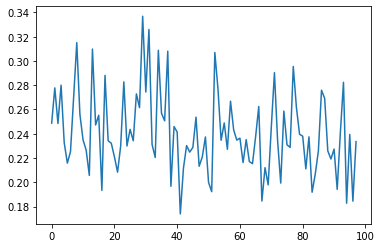

In [28]:
run.recorder.plot_loss()

## Parameter Scheduler

In [29]:
# export
class ParamScheduler(Callback):
    _order = 1

    def __init__(self, pname, sched_funcs):
        self.pname = pname
        self.sched_funcs = sched_funcs

    def begin_fit(self):
        if not isinstance(self.sched_funcs, (list, tuple)):
            self.sched_funcs = [self.sched_funcs] * len(self.opt.param_groups)

    def set_param(self):
        assert len(self.opt.param_groups) == len(self.sched_funcs)
        for pg, f in zip(self.opt.param_groups, self.sched_funcs):
            pg[self.pname] = f(self.pct_train)

    def begin_batch(self):
        if self.training:
            self.set_param()

In [30]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 

In [31]:
learn = create_learner(get_model, loss_func, data)

In [32]:
run = Runner(cbs=[AvgStatsCallback([accuracy]),
                  ParamScheduler('lr', sched)],
             cb_funcs=Recorder)

In [33]:
run.fit(3, learn)

/Users/imad/Documents/courses/fastai-courses/dl2/notebooks/exp/nb_05.py:81: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1595629430416/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx = (pos >= pcts).nonzero().max()


train: [0.7839521875, tensor(0.7784)]
valid: [0.340990478515625, tensor(0.9010)]
train: [0.30294220703125, tensor(0.9125)]
valid: [0.248506787109375, tensor(0.9279)]
train: [0.2439533203125, tensor(0.9297)]
valid: [0.219494580078125, tensor(0.9380)]


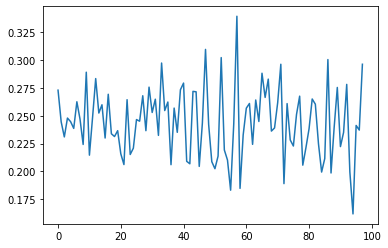

In [34]:
run.recorder.plot_loss()

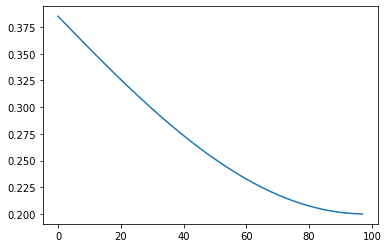

In [35]:
run.recorder.plot_lr()

## LR Finder

NB: You may want to also add something that saves the model before running this, and loads it back after running - otherwise you'll lose your weights!

In [36]:
# export
class LR_Find(Callback):
    _order = 1

    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter = max_iter
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.best_loss = 1e9

    def begin_batch(self):
        if not self.training:
            return
        pos = self.n_iters / self.max_iter
        lr = self.min_lr * (self.max_lr / self.min_lr)**pos
        for pg in self.opt.param_groups:
            pg['lr'] = lr

    def after_step(self):
        if self.n_iters >= self.max_iter or self.loss > self.best_loss * 10:
            raise CancelFitException()
        elif self.loss < self.best_loss:
            self.best_loss = self.loss

NB: In fastai we also use exponential smoothing on the loss. For that reason we check for `best_loss*3` instead of `best_loss*10`.

In [37]:
learn = create_learner(get_model, loss_func, data)

In [38]:
run = Runner(cb_funcs=[LR_Find, Recorder])

In [39]:
run.fit(2, learn)

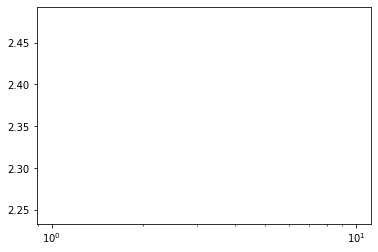

In [40]:
run.recorder.plot(skip_last=5)

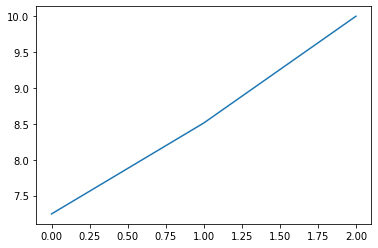

In [41]:
run.recorder.plot_lr()

# Export

In [42]:
!python ../src/notebook2script.py 05b_Early_Stopping-Imad.ipynb

Converted 05b_Early_Stopping-Imad.ipynb to exp/nb_05b.py
